前回までのコード(データ作成)

[[-3.97767806 -2.87745786]
 [-0.9719314  -1.25367045]
 [-3.23128748  0.06909557]
 ..., 
 [ 2.07154822  0.53599364]
 [ 1.08521593  3.61521411]
 [ 1.70017147  1.10197914]]
[[ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]]


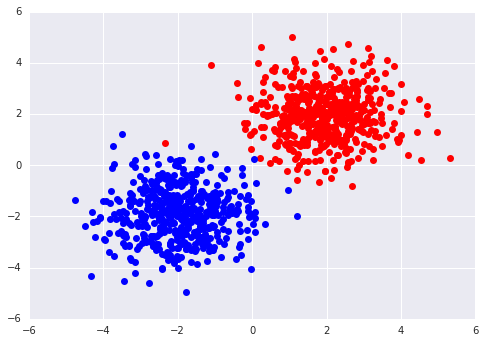

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

x_positive = np.random.randn(500, 1) + 2
y_positive = np.random.randn(500, 1) + 2
x_negative = np.random.randn(500, 1) - 2
y_negative = np.random.randn(500, 1) - 2

plt.figure(1)
plt.plot(x_positive, y_positive, 'ro', label='Data1')
plt.plot(x_negative, y_negative, 'bo', label='Data2')

N = len(x_positive)
POSITIVE = np.zeros((N,2))
for i in xrange(N):
  POSITIVE[i][0] = x_positive[i]
  POSITIVE[i][1] = y_positive[i]

NEGATIVE = np.zeros((N,2))
for i in xrange(N):
  NEGATIVE[i][0] = x_negative[i]
  NEGATIVE[i][1] = y_negative[i]

VIRUS = np.vstack([NEGATIVE, POSITIVE]).astype(np.float32)

print VIRUS

STATE = np.zeros((N*2,2), dtype=np.float32)
for i in xrange(N*2):
  if i < N:
    STATE[i][1] = 1
  else:
    STATE[i][0] = 1

print STATE

TensorFlow処理

In [155]:
from tensorflow.python.framework.graph_util import convert_variables_to_constants

tf.reset_default_graph()
LOGDIR = "./data_virus"
 
# TensorBoardへの反映
#w_graph = tf.summary.histogram("W_graph", w)
#b_graph = tf.summary.histogram("b_graph", b)
#y_graph = tf.summary.histogram("y_graph", y)
#cost_graph = tf.summary.scalar("cost_graph", cost)


with tf.Graph().as_default(): 
  x = tf.placeholder(tf.float32, shape=(None,2), name="input")
  y = tf.placeholder(tf.float32, shape=(None,2), name="output")
  w = tf.Variable(tf.random_normal([2,2], stddev=0.01), dtype=tf.float32, name="weight")
  b = tf.Variable(tf.random_normal([2], stddev=0.01), dtype=tf.float32, name="bias")

  # ロジスティック回帰のモデルを定義
  y_pred = tf.nn.softmax(tf.matmul(x,w) + b, name="y_pred")
  
  # コストの計算
  loss = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=y_pred)
  cost = tf.reduce_mean(loss, 0, name="cost")

  # 精度の計算
  correct_pred = tf.equal(tf.argmax(y_pred,1), tf.argmax(STATE,1))
  accuracy_op = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name="accuracy")

  # 予測
  predict_op = tf.argmax(y_pred, 1, name="predict_op")
  
  with tf.Session() as sess:
    
     # 初期化処理
    init_op = tf.global_variables_initializer()
    sess.run(init_op)

    # トレーニング
    learning_rate = 0.01
    train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
  
    # Summary
    summary_writer = tf.summary.FileWriter(LOGDIR, sess.graph)
    summary_op = tf.summary.merge_all()
  
    
    # トレーニング回数
    training_step = 1000
    validation_step = 100

    # トレーニング
    for step in xrange(training_step):
      sess.run(train_op, feed_dict={x: VIRUS, y: STATE})

      if step % validation_step == 0:
        accuracy_output,cost_output = sess.run([accuracy_op,cost], feed_dict={x: VIRUS, y: STATE})
        print "step %d, cost %f, accuracy %f" % (step,cost_output,accuracy_output)

        # TensorBoardにも反映
        #summary_str = sess.run(summary_op, feed_dict={x: VIRUS, y: STATE})
        #summary_writer.add_summary(summary_str, step)

    # check anser
    data = [[-2,-2]]
    x_check = np.array(data)
    flag_pos = sess.run(predict_op, feed_dict={x: x_check})
    print "flag position is %d" % (flag_pos)
    data = [[2,2]]
    x_check = np.array(data)
    flag_pos = sess.run(predict_op, feed_dict={x: x_check})
    print "flag position is %d" % (flag_pos)

    minimal_graph = convert_variables_to_constants(sess, sess.graph_def, ["y_pred", "predict_op", "accuracy", "cost"])

    tf.train.write_graph(minimal_graph, '.', 'minimal_graph.proto', as_text=False)
  
    summary_writer.flush()
    
  sess.close()


step 0, cost 0.682563, accuracy 0.998000
step 100, cost 0.402190, accuracy 0.998000
step 200, cost 0.367502, accuracy 0.997000
step 300, cost 0.354013, accuracy 0.997000
step 400, cost 0.346680, accuracy 0.997000
step 500, cost 0.342009, accuracy 0.997000
step 600, cost 0.338744, accuracy 0.997000
step 700, cost 0.336317, accuracy 0.997000
step 800, cost 0.334433, accuracy 0.997000
step 900, cost 0.332923, accuracy 0.997000
flag position is 1
flag position is 0
INFO:tensorflow:Froze 2 variables.
Converted 2 variables to const ops.


保存したモデルを評価

In [156]:
def showLog():
  print('=' * 60)
  for op in tf.get_default_graph().get_operations():
    print(op.name)
    for output in op.outputs:
      print('  ', output.name)
  print('=' * 60)

from tensorflow.python.platform import gfile

with tf.Graph().as_default():
  with open('minimal_graph.proto', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.import_graph_def(graph_def, name='')
    persisted_result = persisted_sess.graph.get_tensor_by_name("predict_op:0")

    with tf.Session() as sess:
      data = [[-2,-2]]
      x_check = np.array(data)
      flag_pos = sess.run(persisted_result, feed_dict={x: x_check})
  

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("input:0", shape=(?, 2), dtype=float32) is not an element of this graph.

In [152]:
!ls -la minimal*

-rw-r--r-- 1 root root 11242 Feb  6 01:12 minimal_graph.proto
-rw-r--r-- 1 root root 41953 Feb  6 01:12 minimal_graph.txt
